In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
                        recall_score, f1_score, roc_auc_score


sns.set(style='dark', font_scale=1.7)

# 1. Логистическая регрессия

### [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


 *   Наиболее важные параметры:
*   `penalty` -- задает норму регуляризатора из множества `{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}` по умолчанию `’l2’`
*   `C` -- константа, обратная к константе перед регуляризацией, т.е. меньшие значения указывают на более сильную регуляризацию.
*   `fit_intercept` -- указывает, следует ли добавить константу к исходным признакам
*   `multi_class` -- стратегия при мультиклассовой классификации из множества `{‘auto’, ‘ovr’, ‘multinomial’}` по умолчанию `’auto’`

 *    Наиболее важные аттрибуты:
*   `coef_` -- оценки коэффициентов логистической регрессии
*   `intercept_` -- оценка коэффициента перед единичным признаком

 *    Методы
* `fit()` -- обучение классификатора
* `predict()` -- предсказание метки класса
* `predict_proba()` -- предсказание вероятностей классов
* `predict_log_proba()` -- предсказание логарифмов вероятностей классов



### Данные
Рассмотрим пример: задача бинарной классификации с несбалансированными классами, два признака, классы линейно не разделимы.

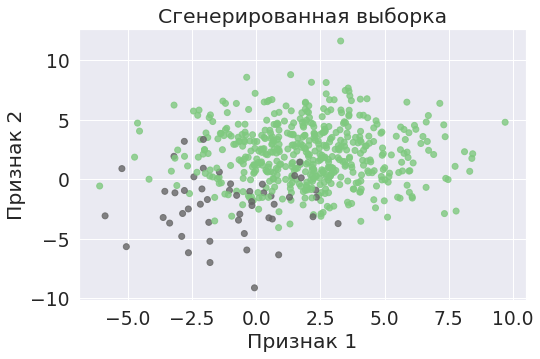

In [2]:
X, y = make_blobs(n_samples=(500, 50), centers=[[2, 2], [-2, -2]], 
                  cluster_std=2.5, random_state=42)

plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

Разделим данные на обучающую и тестовую выборку:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

### Модель

Обучим логистическую регрессию 

In [4]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Получившиеся коэффициенты

In [5]:
clf.coef_

array([[-0.54763338, -0.75980069]])

Коэффициент перед константным признаком

In [6]:
clf.intercept_

array([-1.98607035])

### Результат

График предсказаний вероятности принадлежности классу

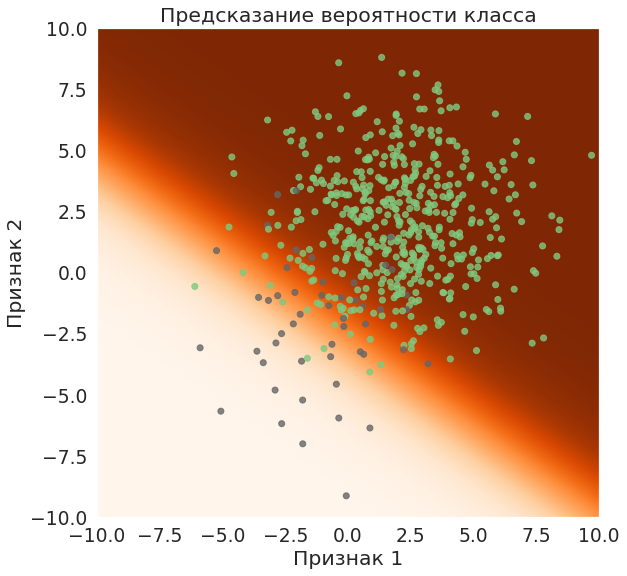

In [7]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-10, 10, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10)), plt.ylim((-10, 10))
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

# 2. Качество классификации

Для бинарной классификации существует множество различных метрик качества:

### 2.1 Accuracy
[Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Данная метрика является самой тривиальной метрикой для задачи классификации и представляет собой долю правильных ответов. 

$$accuracy(y, \widehat{y}) = \frac{1}{n}\sum\limits_{i=1}^{n} {I\{y_i = \widehat{y}_i\}},$$   
  
где $y$ -- вектор истинных классов, $\widehat{y}$ -- вектор предсказанных классов, $n$ -- количество объектов.

**Достоинства**: в основе метрики $accuracy$ лежит простая интуиция.

**Недостатки**:  <br>
Данная метрика плоха в случае дисбаланса классов, когда представителей одного из класса существенно больше, чем другого. <br>
Рассмотрим пример выборки, в которой 950 положительных и 50 отрицательных объектов. Пусть наш классификатор всем объектам выдает класс 1. Тогда его accuracy будет равен 0.95, что является очень неплохим результатом. Однако сама модель при этом не имеет особого смысла: она просто возвращает константу при любом входе. <br>

Это означает, что доля правильных ответов сама по себе не несет никакой информации о качестве работы модели, и вместе с ней следует анализировать соотношение классов в выборке.


Посмотрим на accuracy в нашей задаче.

In [8]:
accuracy_score(y_test, clf.predict(X_test))

0.927710843373494

В данной ситуации эта метрика не очень информативна, так как классификатор, предсказывающий всегда 1 класс, имел бы accuracy $\approx 90\%$ 


### 2.2 Матрица ошибок (Confusion matrix)
Рассмотрим  матрицу ошибок (confusion matrix) – матрицу размера 2×2, ij-я позиция которой равна числу объектов i-го класса, которым модель присвоила метку j-го класса. Данное понятие нужно осознать и запомнить, так как на основе данной матрицы будут введены более сложные метрики.


<img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg" alt="drawing" width="400"/>


**TN** -- True Negative, количество верно (True) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**FP** -- False Positive, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  
**FN** -- False Negative, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**TP** -- True Positive, количество верно (True) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  




Отметим, что в данной терминологии $accuracy$ можно представить через следующую формулу:  
<br>
$$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Пример** <br>

Пусть мы хотим оценить работу спам-фильтра почты. У нас есть 100 не-спам писем, 90 из которых наш классификатор определил верно и 10 спам-писем, 5 из которых классификатор также определил верно. Будем считать класс не-спам писем отрицательным, а класс спам писем - положительным.


Размер отрицательного класса = TN + FP = 100 <br>
Размер положительного класса = TP + FN = 10

90 не-спам писем из 100 не-спам писем были определены верно $\Rightarrow$ TN = 90, FP = 10 <br>
5 спам писем из 10 спам писем были определены верно $\Rightarrow$ TP = 5, FP = 5 <br>


Данная матрица сама по себе является не метрикой, а инструментом, с помощью которого можно ввести более продвинутые метрики. Тем не менее ее полезно визуализировать, так как она является достаточно информативной. 

### 2.3 Precision

[Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

Точность (Precision, Positive Predictive Value) показывает какой процент объектов, которые метод посчитал положительными, действительно являются положительными.

$$precision(y, \widehat{y}) = \frac{TP}{TP + FP},$$

где $y$ -- вектор истинных классов, $\widehat{y}$ -- вектор предсказанных классов.


**Пример:** <br>

Рассмотрим задачу предсказания реакции клиента банка на звонок с предложением кредита.
Класс $y = 1$ означает, что клиент возьмет кредит после рекламного звонка, класс $y = -1$ - что не возьмет. 
Планируется обзванивать только тех клиентов, которых классификатор отнесет к классу $1$.
Если классификатор имеет высокую точность, то практически все клиенты, которым будет сделано предложение, откликнутся на него.<br>

**Достоинства**: позволяет следить за тем, насколько можно доверять ее положительным предсказаниям (то есть предсказаниям позитивного класса).

**Недостатки**: не позволяет следить за тем, как много положительных объектов способен распознать классификатор.<br>
Например, мы построили модель, которая присваивает позитивный класс очень малому количеству объектов. $Precision$ у такой модели может быть хорошим, но при этом модель присваивает негативный класс очень большому количеству позитивных объектов. 

Померяем данную метрику на нашей задаче

In [9]:
precision_score(y_test, clf.predict(X_test))

0.8333333333333334

### 2.4 Recall
[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

Полнота (Recall, True Positive Rate) показывает какую долю объектов положительного класса модель классифицировала правильно. 

$$recall(y, \widehat{y}) = \frac{TP}{TP + FN},$$

где $y$ -- вектор истинных классов, $\widehat{y}$ -- вектор предсказанных классов.


**Пример:** <br>
Рассмотрим тот же пример предсказания реакции клиента банка на звонок с предложением кредита.<br>
Если классификатор имеет высокую полноту, то предложение будет сделано практически всем клиентам, которые готовы откликнуться на него.


**Достоинства**: позволяет следить тем, как много положительных объектов способен распознать классификатор. 

**Недостатки**: не позволяет следить за точностью модели: насколько можно доверять ее положительных предсказаниям . 


**Замечание 1**:  <br>
Легко построить модель с $recall = 1$: она все объекты относит к классу 1, но при этом $precision$ может быть очень низким. Также нетрудно построить модель с $precision$ близким к $1$: она относит к классу 1 только те объекты, в которых точно уверена, при этом recall может быть низким. 

**Замечание 2**: <br>
Отметим, что точность и полнота не зависят от соотношения размеров классов. <br>
Даже если объектов положительного класса на порядки меньше, чем объектов отрицательного класса, данные показатели будут корректно отражать качество работы модели.



Посчитаем полноту для нашей задачи

In [10]:
recall_score(y_test, clf.predict(X_test))

0.5

### 2.5 F-мера
[F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Хотелось бы получить один критерий, который учитывал бы в себе и точность, и полноту. Существует несколько способов получить один критерий качества на основе точности и полноты.
Один из них -- F-мера, гармоническое среднее точности и полноты:

$$F_1 = \frac{ 2 \cdot precision \cdot recall}{precision + recall}$$

Среднее гармоническое обладает важным свойством -- оно близко к нулю, если хотя бы один из аргументов близок к нулю.
При этом $F_1$ достигает максимума при $precision = 1$ и $recall = 1$.

Рассмотрим другие методы агрегации $precision$ и $recall$ и их недостатки:

1. Среднее арифметическое
$$A = \frac{precision + recall}{2}$$
**Недостатки:** <br>
Пусть есть выборка, в которой 10% объектов -- класс 0. <br>
Модель $a_1$ всегда выдает класс 1 $\Rightarrow precision_{1} = 0.1, recall_{1} = 1$ <br>
$\Rightarrow A_1 = 0.55$ <br>
Модель $a_2$ имеет $precision_{2} = 0.55, recall_{1} = 0.55$ <br>
$\Rightarrow A_2 = 0.55$ <br>
Среднее арифметическое обеих моделей одинаково, однако первая модель совсем бесполезная, а вторая хоть как-то умеет различать классы. 


2. Минимум
$$M = \min(precision, recall)$$
Максимум достигается при $precision = 1$ и $recall = 1$. <br><br>
**Недостатки:** <br>
Пусть модель $a_1$ имеет $precision_{1} = 0.4, recall_{1} = 0.9$ <br>
$\Rightarrow M_1 = 0.4$ <br>
А модель $a_2$ имеет $precision_{2} = 0.4, recall_{2} = 0.5$ <br>
$\Rightarrow M_2 = 0.4$ <br>
Минимумы двух моделей одинаковы, однако очевидно, что первая модель гораздо лучше.


Можно заметить, что F-мера по сути является сглаженной версией минимума из точности и полноты и поэтому она лишена минусов двух рассмотренных метрик.

Посчитаем F-меру для нашей задачи

In [11]:
f1_score(y_test, clf.predict(X_test))

0.625

# 3. Случай линейно разделимых классов

Теперь рассмотрим случай, когда классы линейно разделимы:

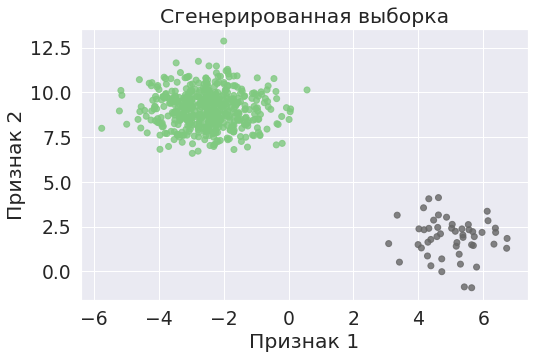

In [12]:
X, y = make_blobs(n_samples=(500, 50), random_state=42)

plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

Разделим выборку:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((467, 2), (83, 2), (467,), (83,))

Обучим модель:

In [14]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

И посмотрим на метрики:

In [15]:
print('accuracy: ', accuracy_score(y_test, clf.predict(X_test)))
print('precision: ', precision_score(y_test, clf.predict(X_test)))
print('recall: ', recall_score(y_test, clf.predict(X_test)))
print('f1-score: ', f1_score(y_test, clf.predict(X_test)))

accuracy:  1.0
precision:  1.0
recall:  1.0
f1-score:  1.0


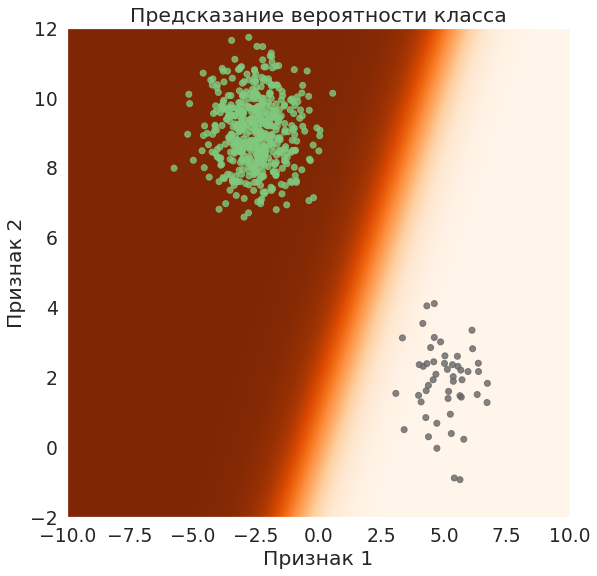

In [16]:
x0_grid, x1_grid = np.meshgrid(np.linspace(-10, 10, 2001), 
                               np.linspace(-2, 12, 2001))
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001*2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap='Oranges')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.xlim((-10, 10)), plt.ylim((-2, 12))
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Предсказание вероятности класса');

Видим, что классы разделены правильно. Вопреки теории здесь не возникло переобучения, при котором оценка вероятностей всех классов будет 0 или 1. Причина в том, что по умолчанию используется регуляризация, управлять которой можно с помощью параметра `C`.